Notebook is copyright &copy; of <a href="https://ajaytech.co">Ajay Tech</a>

# Decision Trees

## Contents

- [What are Decision trees](#What-are-Decision-Trees)
- [Implementation](#Implementation)
- [Visualization](#Visualization)
- [Gini Index](#Gini-Index)
- [Decision Trees for Regression](#Decision-Trees-for-Regression)
- [Overfitting](#Overfitting)
- [Pruning - Solution to Overfitting](#Pruning--Solution-to-Overfitting)
    - [Tree Depth](#Tree-Depth)
    - [Impurity](#Impurity)

### What are Decision Trees

Let me take you back to the number guessing game that we have played on day 1 of the course. It is a simple game where the computer chooses a random number between 1 and 100 and you have to guess the number. After each guess, the program helps you by telling if your guess is higher or lower than the chosen number. Say the number chosen is 60. Let's visualize this.

<img src="./pics/number-guessing-game-visual.png"/>

Basically, it is a series of decisions based on the clue you get from the program. For lack of a better intelligence, we just predict the middle number on either side ( higher or lower ). We can think of the same process using a decision tree.

<img src="./pics/decision-tree-guessing-game.png"/>

A decision tree is essentially a series of decisions that are based on the data you are working with. For example, if you are guessing a number between 1 and 1000, the decision tree would have been much bigger. In this case, the guesses (cuts in the number line) are exactly in the middle - for lack of a better guessing method. However, a real decision tree makes a much more informed decision. Once again, let me show this with a simple example. 

Take an apple that is rotten somewhere at the side. 

<img src="./pics/decision-tree-rotten-apple.png"/>

Our goal is to find a series of cuts that maximises the fresh apple portion (and minimizes the rotten portion) with the least possible cuts. How would you do it ?

<img src="./pics/decision-trees-apple-cuts.png"/>

Something like this - The criteria you would be using to make the cuts is based on the maximum area(volume) that you can carve off that is not rotten. 

Decision trees also work the same way. For example, let's take the iris dataset. To make things simple, let's just focus on 
- setosa and versicolor
- sepal length and sepal width.

<img src="./pics/iris-setosa-versicolor.png"/>

If you are asked to carve out one species from another using just horizontal and vertical lines, how would you do it ? It's not an easy job to do it efficiently. Probably, we would do it something like this. 


<img src="./pics/iris-manual-decision-tree.png"/>

What were we basing our decisions (cut-off points) on ? Visually, we were essentially eye-balling to minimize the mix of species(or maximize the grouping of a single species) in such a way that more of a specific species fell on one side than the other. 

Decision tree algorithms do just this - except that they use a bit of math to do the same. Scikit learn provides two cost functions for this
- Gini Index ( default )
- Entropy

We will start with the basic implementation and then we will focus on understand Gini Index in a bit more detail.

### Implementation

In [2]:
library(rpart)
names(iris)

[1] "Sepal.Length" "Sepal.Width"  "Petal.Length" "Petal.Width"  "Species"

In [3]:
model <- rpart(Species ~ Sepal.Length + Sepal.Width, method="class", data=iris[1:100,])

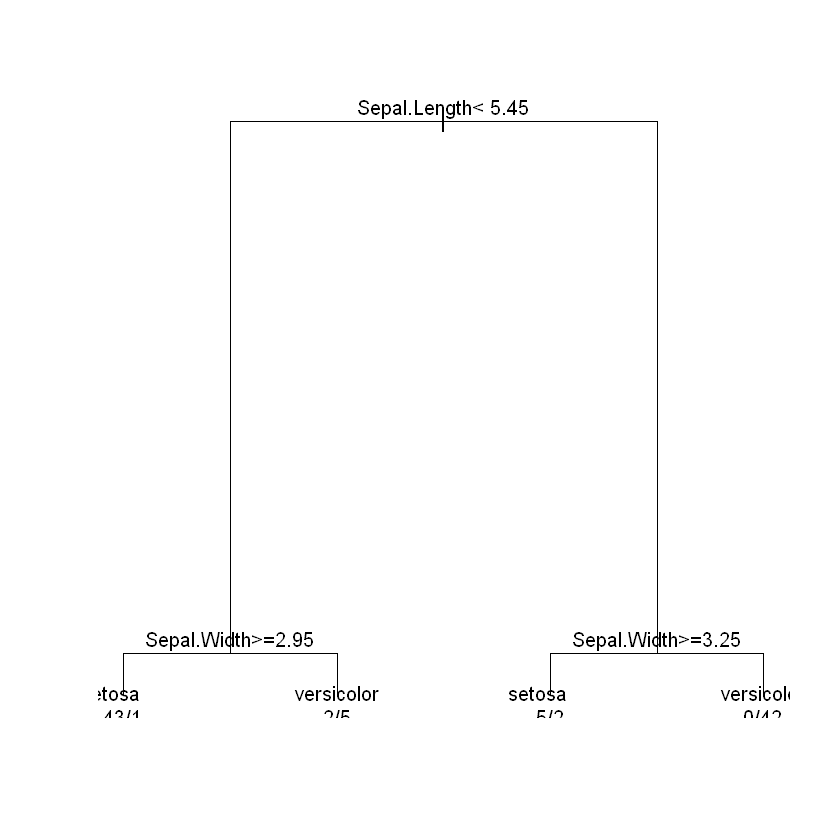

In [4]:
plot(model)
text(model, use.n = TRUE)

### Visualization

One of the biggest advantages of Decision Trees is that the whole process is very intuitive to humans. It is more or less like a white-box ( as opposed to other methods like Neural Nets that are like blackboxes - We just can't make sense of the weights and layers ).  A useful method to understand Decision Trees is to visualize them. To do that, we have to install the graphviz package. Let's do that first.

With this function, some of the text gets split off. So, a better representation would be to create a **ps** or *postscript* file, which can be either viewed directly or converted to a pdf to be viewed. 

In [28]:
post(model, file = "tree.ps",
     title = "Iris (Setosa/Versicolor) simple decision tree ")

You can either use a **ps** file viewer or convert it to **pdf** and view it. 

<img src="./pics/setosa-versicolor-regression-tree.png"/>

In [42]:
y_pred = predict ( model, newdata = iris[1:100,], "class")

In [49]:
library(caret)

cm = confusionMatrix(y_pred,iris[1:100,5])
cm

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         48          3         0
  versicolor      2         47         0
  virginica       0          0         0

Overall Statistics
                                          
               Accuracy : 0.95            
                 95% CI : (0.8872, 0.9836)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9             
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 0.9600            0.9400               NA
Specificity                 0.9400            0.9600                1
Pos Pred Value              0.9412            0.9592               NA
Neg Pred Value              0.9592            0.9412               NA
P

### Gini Index

Let's analyze how the Decision Tree algorith has made these decisions. First, let's create a scatter plot of our data.

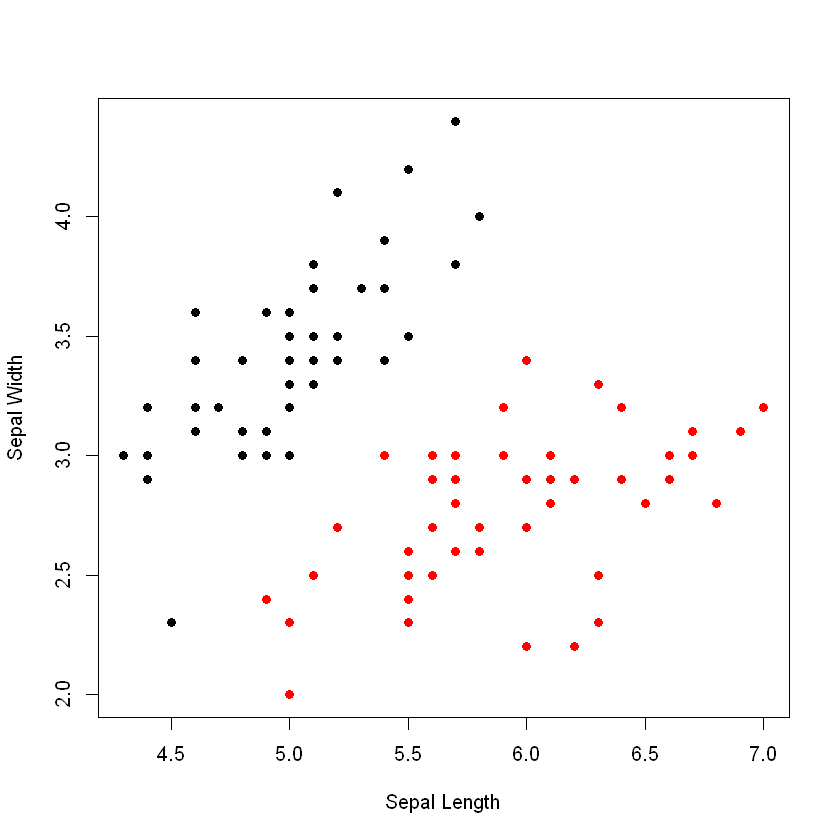

In [5]:
iris_new = iris[0:100,]
plot(iris_new$Sepal.Length, iris_new$Sepal.Width, 
     col = iris_new$Species, pch = 19, 
     xlab = "Sepal Length",
     ylab = "Sepal Width")

The key parameters used by Decision Tree are either of the following

- gini index
- entropy

By default DecisionTreeClassifier uses the gini index to calculate the cut-offs. Let's focus on the gini index cost function.

Let's look at the first cut , 

<pre>
sepal length (cm) < = 5.45
</pre>

Let's do some calculations by hand. It will give us a better understanding of what is going on under the hood.

Formula to calculate Gini index is

# $ gini = 1 - \sum_{i} p_i^2 $

where p<sub>i</sub> is the probability of occurance of the i'th class. In our case, we have just 2 classes.
- setosa
- versicolor

<img src="./pics/decision-tree-first-cut.png"/>

The above visual demonstrates how the calculations have been done.

Initial gini index.

### $ 1 - \frac{50}{100}^2 - \frac{50}{100}^2  = 0.5 $

Gini indices after the first cut has been made.

### $ 1 - \frac{45}{51}^2 - \frac{6}{51}^2  = 0.208 $

### $ 1 - \frac{5}{49}^2 - \frac{44}{49}^2  = 0.183 $

so, gini index after the split is
<pre>
0.208 + 0.183 = 0.391
</pre>

which is less than the original gini index that we started with - 0.5

Now, the question arises, why did the first cut happen at sepal length <= 5.45 ?  Why not at 6.0 ? To understand this, let's actually make a cut at sepal length <= 6.0 and re-calculate the gini indices.

- **Identify the target counts by class**

In [10]:
table(iris_new [iris_new$Sepal.Length <= 6,]$Species)


    setosa versicolor  virginica 
        50         30          0 

- **Calculate the Gini Index**

### $ 1 - \frac{50}{80}^2 - \frac{30}{80}^2  = 0.468 $

<img src="./pics/decision-tree-arbitrary-cut.png"/>

The gini index at the new cut-off sepal length <= 6.0 is 0.468. It is not much different from where we initially started (0.5). By now, you should be able to understand the reasons behind the classifier's decision points.

#### Challenge

Try to calculate the gini index by hand(like above) when the sepal width <=2.75

Here is a visual of how decision tree algorithm has eventually solved the problem. 

<img src="./pics/decision-tree-solves-iris.png"/>

Now that we understand how decision trees work, let's try and predict some data. Let's first split our data into train/test datasets.

In [84]:
data = iris_new

index = sample(1:nrow(data),nrow(data)*.8)
train = data[index,]
test = data[-index,]

In [85]:
library(rpart)

model <- rpart(Species ~ Sepal.Length + Sepal.Width, method="class", data=train)
y_pred = predict ( model, newdata = test, "class")

In [86]:
library(caret)

cm = confusionMatrix(y_pred,test[,5])
cm

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa          7          3         0
  versicolor      0         10         0
  virginica       0          0         0

Overall Statistics
                                          
               Accuracy : 0.85            
                 95% CI : (0.6211, 0.9679)
    No Information Rate : 0.65            
    P-Value [Acc > NIR] : 0.04438         
                                          
                  Kappa : 0.7             
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.7692               NA
Specificity                 0.7692            1.0000                1
Pos Pred Value              0.7000            1.0000               NA
Neg Pred Value              1.0000            0.7000               NA
P

Thats an accuracy score of 88%. Pretty decent. 

### Decision Trees for Regression

Although decision trees are mostly used for classification problems, you can use them for regression as well.

Let's try to fit the Boston Housing dataset with decision trees. Just to make things simple, let's just use the LSTAT predictor to predict the target.

In [26]:
library(mlbench)
data(BostonHousing)
boston        = BostonHousing

In [34]:
index = sample(1:nrow(boston),nrow(boston)*.8)
train = boston[index,]
test = boston[-index,]

In [49]:
model = train(medv ~ lstat, 
              data = train, 
              method = "rpart", 
              trControl = trainControl("cv", number = 15), 
              tuneLength = 15)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


In [50]:
y_pred = predict ( model, newdata = test)

In [51]:
# Use the in-built "score" function of the regressor to calculate the R-squared
RMSE(y_pred, test$medv)

[1] 5.388488

Let's plot the predictions on top of the data to visually see how well the prediction does in comparision to the actual data.

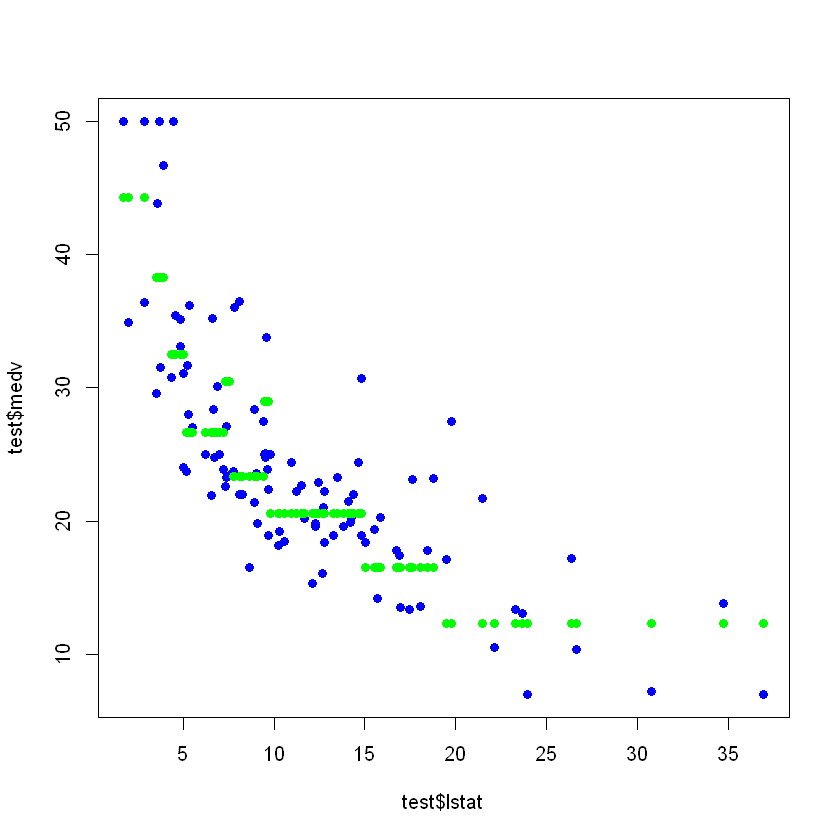

In [52]:
plot( test$lstat, test$medv, pch = 19, col="blue")
points ( test$lstat, y_pred, pch = 19, col = "green")

As you can see from this plot, Decision Tree's prediction for regression is step wise (as opposed to being smooth). This is because, decision trees work by averaging the data to be predicted to the nearest neighbors. You can try this by changing the parameters in the model, like **trainControl** and **tuneLength**. Also, instead of parameters like Gini Index or Entropy, Decision trees use RMSE to calculate the splits in case of regression.

### Overfitting

One of the main drawbacks of Decision Trees is _overfitting_. We can very well observe that the model fits the training data 100%, but when it comes to test data, there would be a huge variation. Such a large variation is something that you do NOT observe in other models - say linear regression. Let's try and fit the iris data again (this time with all the 3 species).

In [65]:
index = sample(1:nrow(iris),nrow(iris)*.8)
train = iris[index,]
test = iris[-index,]

In [4]:
library(caret)
library(rpart)


test_score     = list()
train_score = list()

for (i in 1:100) {
    
    index = sample(1:nrow(iris),nrow(iris)*.8)
    train = iris[index,]
    test  = iris[-index,]

    model        = rpart(Species ~ ., method="class", data=train)
    y_pred_train = predict ( model, newdata = train, "class") 
    y_pred_test  = predict ( model, newdata = test, "class")
    
    cm_train       = confusionMatrix(y_pred_train,train[,5])
    accuracy_train = cm_train$overall["Accuracy"]
    
    cm_test       = confusionMatrix(y_pred_test,test[,5])
    accuracy_test = cm_test$overall["Accuracy"]
    
    train_score[[i]] = accuracy_train
    test_score[[i]]  = accuracy_test
}

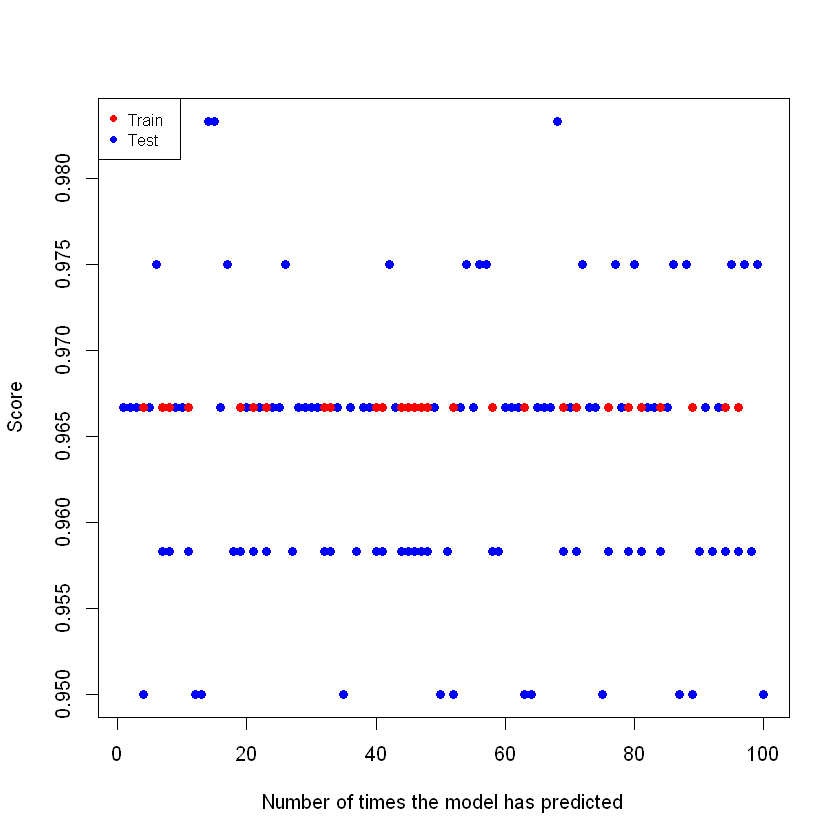

In [20]:
plot ( 1:100, train_score, pch = 19, col = "blue",
       xlab = "Number of times the model has predicted",
       ylab = "Score")
points ( 1:100, test_score, pch = 19, col = "red")
legend ( x= "topleft", legend = c("Train", "Test"), col=c("red", "blue"), pch=19, cex=0.8)

As you can see, the training accuracy is fixed, but the test results are all over (although the range is quite limited in this case). What is essentially happening is that the model is trying to learn the noise as well. One solution to this is to limit the tree size. This is called pruning. One solution is to find out a parameter called **Complexity Parameter** or **cp**. It is used as a cut-off parameter to identify the minimum value needed at a decision tree node to identify if it should go forward with another split or not. It is based on the cost of the entire tree so far ( with all its splits ). So, a simple cutoff can be used to identify at what level (of tree size) should the tree be pruned. 

Luckily, **rpart** can give us a graph of **cp** at different tree sizes. **plotcp** can also plot this for us. 

#### Tree Depth

Look at the depth of the decision tree for iris data.

<img src="./pics/iris-decision-tree.png">

In this decision tree, after a tree depth of 3, there is no real value addition. It's basically nitpicking at the small numbers - and that's exactly what is leading to overfitting. What is we can restrict the tree to just 3 levels of depth ? 

<img src="./pics/iris-decision-tree-overfitting.png"/>

In [25]:
model <- rpart(Species ~ ., method="class", data=iris)

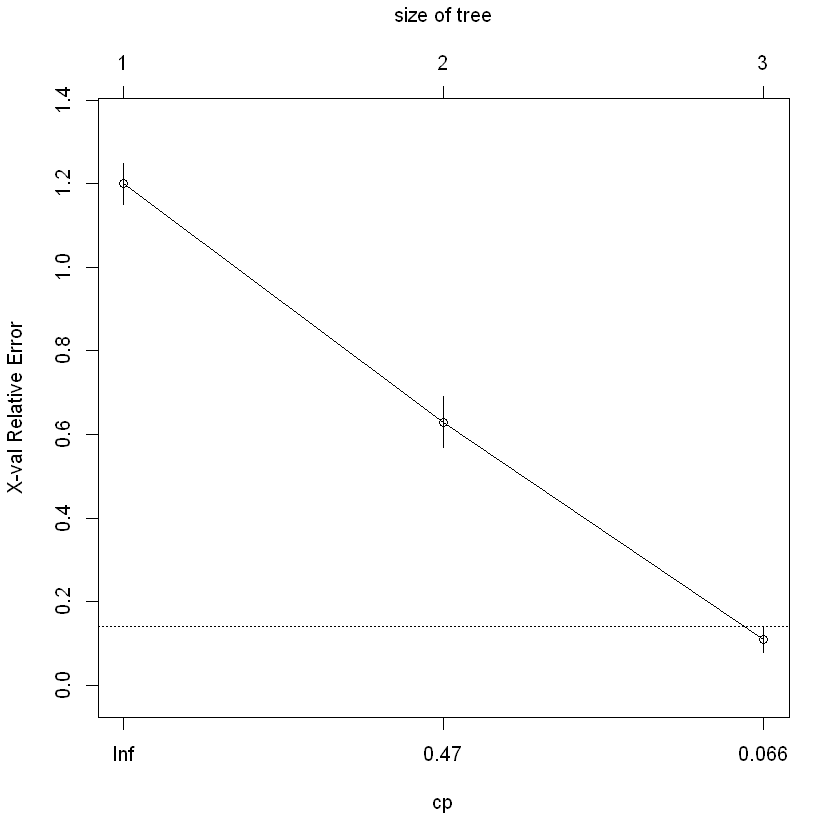

In [26]:
plotcp(model)

As you can see from the plot above, beyond a tree size of tree (at cp value of 0.66), the tree starts to overfit the data. The relative accuracy (on the y-axis) is computed using cross validation. Let's prune the tree at a **cp** of 0.66.

#### Pruning - Solution to Overfitting

Overfitting is basically a problem where the model tries to fit all of the training data. Since there are many borderline cases, it is not practical to fit all the data points for any ML model. In order to avoid this, we have to prune (cut off some of it's branches) the tree to make it an a better fit for the training data - rather than a 100% fit. There are 2 ways to prune a tree.

- **Pre-Pruning** - Prune the decision tree while it is being created.
- **Post-Pruning** - Prune the decision tree after the entire tree has been created.

In [27]:
model_new = prune(model, cp = 0.066)

Let's plot the decision tree of both the old and new (pruned) model to see how they perform.

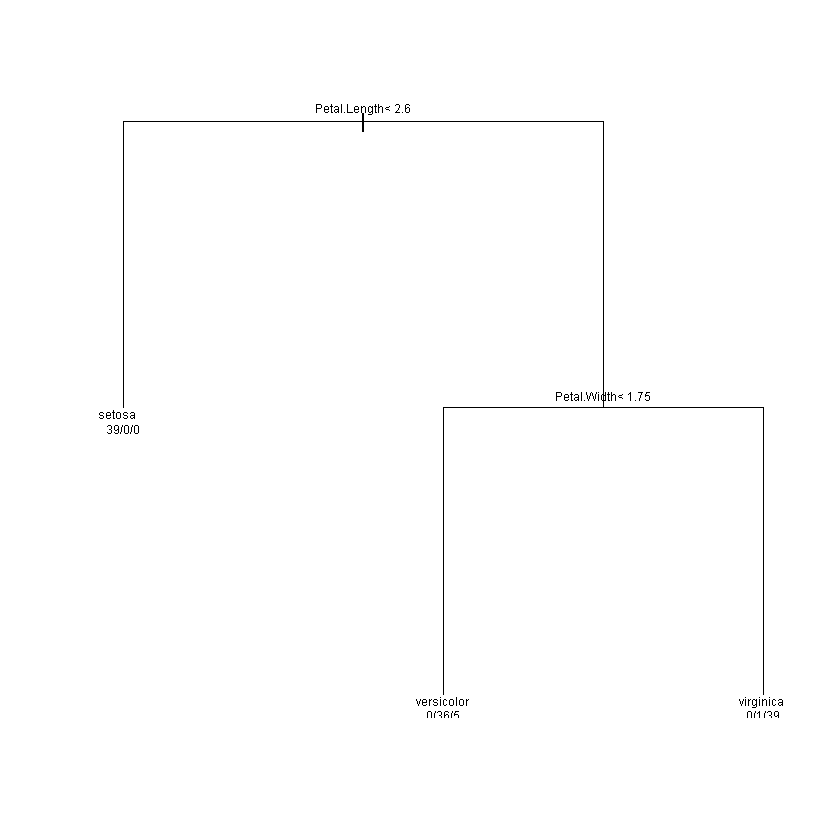

In [24]:
plot(model_new, uniform = TRUE)
text(model_new, use.n = TRUE, cex = 0.6) # cex controls scaling

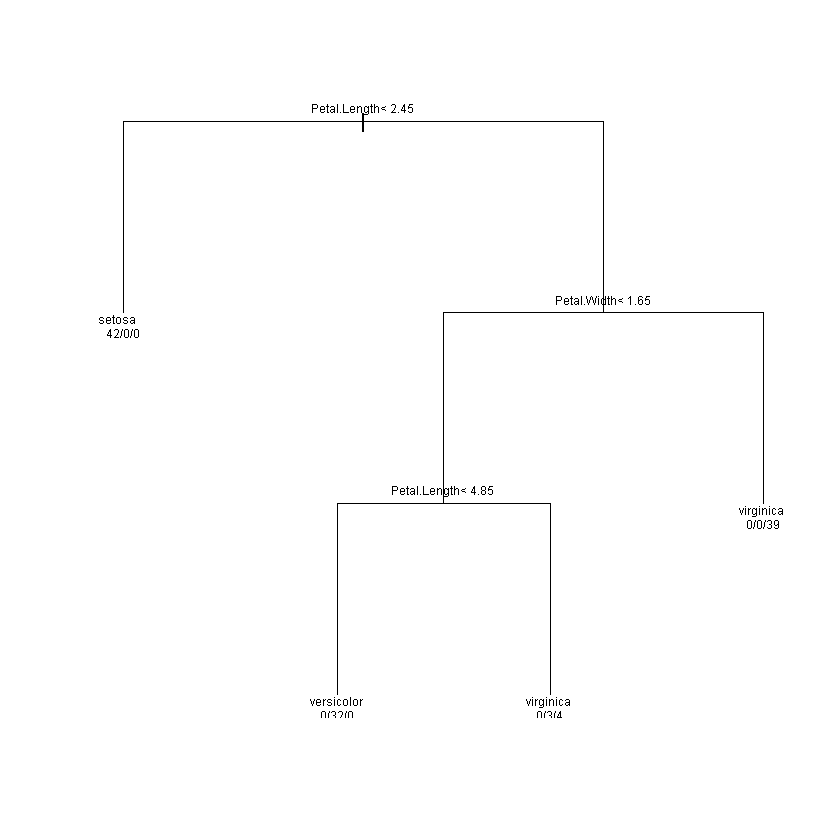

In [76]:
plot(model, uniform = TRUE)
text(model, use.n = TRUE, cex = 0.6) # cex controls scaling

As you can see from the numbers, the actual seperation of species is really small to warrant a new branch. 

In [69]:
printcp(model)


Classification tree:
rpart(formula = Species ~ ., data = train, method = "class")

Variables actually used in tree construction:
[1] Petal.Length Petal.Width 

Root node error: 77/120 = 0.64167

n= 120 

        CP nsplit rel error   xerror     xstd
1 0.545455      0  1.000000 1.103896 0.064664
2 0.402597      1  0.454545 0.454545 0.064664
3 0.012987      2  0.051948 0.090909 0.033343
4 0.010000      3  0.038961 0.103896 0.035487


If you run the same plot and see how different the training and the test data looks, you will get an understanding of how we were able to prevent overfitting. 

<img src="./pics/decision-tree-max-depth-comparision.png"/>